In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time

path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"

#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


## Data set import

In [2]:
class loaded:
    def __init__(self,t=20):
        data = np.load(datapath+"X_data_15.npz") #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+"y_data_15.npz") #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys=['Leather', 'Cork', 'wool', 'LacedMatt', 'Gfoam', 'Plastic', 'Carpet', 'bubble', 'Efoam', 'cotton', 'LongCarpet', 'Flat', 'felt', 'Jeans', 'Ffoam']

        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        self.X = self.AugmentedX
        self.y = self.Augmentedy
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
        del self.AugmentedX
        del self.Augmentedy
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined
#data=loaded(t=13)
#data.applySobel()
#data.augment()

In [3]:
data=loaded(0,4)
print(data.X.shape)

Dataset size: 7600 
Window size: 20 
Image: (110, 120)
Memory needed: 1.87 GB
(7600, 4, 110, 120)


In [6]:
print(np.unique(data.y),"\n",data.keys)
#cork 38-0
#wool 19-1
#lacedMatt 28-2
#gfoam 30-3
#carpet 31-4
#bubble 37-5
#efoam 21-6
#cotton 29-7
#longCarpet 25-8
#flat 16-9
#felt 34 -10
#jeans 39-11
#ffoam 36-12
new_y=np.zeros_like(data.y)
new_y[np.where(data.y==38)]=0
new_y[np.where(data.y==19)]=1
new_y[np.where(data.y==28)]=2
new_y[np.where(data.y==30)]=3
new_y[np.where(data.y==31)]=4
new_y[np.where(data.y==37)]=5
new_y[np.where(data.y==21)]=6
new_y[np.where(data.y==29)]=7
new_y[np.where(data.y==25)]=8
new_y[np.where(data.y==16)]=9
new_y[np.where(data.y==34)]=10
new_y[np.where(data.y==39)]=11
new_y[np.where(data.y==36)]=12

np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/X_textures13",data.X)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/y_textures13",data.y)


[16 19 21 25 28 29 30 31 34 36 37 38 39] 
 {'Cork': 38, 'wool': 19, 'LacedMatt': 28, 'Gfoam': 30, 'Carpet': 31, 'bubble': 37, 'Efoam': 21, 'cotton': 29, 'LongCarpet': 25, 'Flat': 16, 'felt': 34, 'Jeans': 39, 'Ffoam': 36}


In [3]:
def genData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(frm=frm,t=to)
    data.applySobel()
    data.augment()
    data.resize(percentage)
    n=int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to)*data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique

def gen3DData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(frm=frm,t=to)
    data.applySobel()
    data.augment()
    data.resize(percentage)
    n=int(len(data.X)*0.6)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique

## Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self,input_height, input_width):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        height = input_height
        width = input_width
        
        height = height // 2  # after first pooling
        width = width // 2
        height = height // 2  # after second pooling
        width = width // 2
        
        # Number of output features from conv layers (channels * height * width)
        self.flatten_size = 10 * height * width
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 13)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Simple3DCNN(nn.Module):
    def __init__(self, input_depth, input_height, input_width):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        
        depth = input_depth
        height = input_height
        width = input_width
        
        depth = depth // 2  # after first pooling
        height = height // 2
        width = width // 2
        
        depth = depth // 2  # after second pooling
        height = height // 2
        width = width // 2
        
        # Number of output features from conv layers (channels * depth * height * width)
        self.flatten_size = 10 * depth * height * width
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 13)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Train

In [5]:
# Define the Loss Function and Optimizer
def run(train_loader,frm,to):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    model = SimpleCNN(image.shape[0],image.shape[1]).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

def run3D(train_loader,frm,to):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    model = Simple3DCNN(image.shape[0],image.shape[1],image.shape[2]).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

In [6]:
def calc(model,data_loader):
        correct=0
        summed=0.1
        for i, (inputs, labels) in enumerate(data_loader):
            outputs = model(inputs)
            a=torch.argmax(outputs,axis=1)==torch.argmax(labels,axis=1)

            summed+=len(inputs)
            correct+=len(a[a==1])
        print("Accuracy:",(correct/summed)*100,"%")
        return correct/summed


In [ ]:
ar=[]
acc=[]
for i in range(5):
    try:
        torch.cuda.empty_cache()
        train_loader,test_loader,unique=genData(0,4)
        model,history=run(train_loader,0,4)
        ar.append(history)
        print(calc(model,test_loader))
        print(calc(model,train_loader))
        acc.append(calc(model,test_loader))
    except MemoryError as e:
        try:
            del train_loader
            del test_loader
            del model
        except: 
            pass
ar=np.array(ar)
acc=np.array(acc)


np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/accuracies_of_sil",acc)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/loss_of_sil",ar)

In [ ]:
test_scores=np.zeros((10,14,3))
train_scores=np.zeros((10,14,3))
t_averages=np.zeros((10*14*3))

#test_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/test_scores.npy")
#train_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/train_scores.npy")
c=0
for i in range(1,10): #loop through frm dimention
    for j in range(i+1,15): #loop though to dimention
        print(">>>>",i,j,"\nMax:",np.max(test_scores)*100,"%","\nEstimated time left:",(np.average(t_averages[t_averages!=0])*len(t_averages[t_averages==0]))/60,"minutes")
        for trial in range(3):
            t=time.time()
            torch.cuda.empty_cache()
            train_loader,test_loader,__=genData(i,j)
            model=run(train_loader,i,j)
            test_scores[i][j-1][trial]=calc(model,test_loader)
            train_scores[i][j-1][trial]=calc(model,train_loader)
            torch.cuda.empty_cache()
            del train_loader
            del test_loader
            del model
            t2=time.time()
            t_averages[c]=t2-t
            c+=1
        clear_output(wait=True)
        np.save(path+"saves/test_scores",test_scores)
        np.save(path+"saves/train_scores",train_scores)




### Look at resolution

In [ ]:
resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
test_scores=np.zeros((len(resolutions),5))
train_scores=np.zeros((len(resolutions),5))
for i,res in enumerate(resolutions):
    print("RESOLUTIONS",i,"/",len(resolutions))
    for trial in range(5):
        train_loader,test_loader,unique=genData(0,4,res)
        model,history=run(train_loader,0,4)
        test_scores[i][trial]=calc(model,test_loader)
        train_scores[i][trial]=calc(model,train_loader)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/resolutions_train",train_scores)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/resolutions_test",test_scores)


In [18]:
image=next(iter(train_loader))
print(image[0][0][0].shape)

torch.Size([440, 120])


### Look at performance

In [ ]:
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=genData(0,4)
    model,history=run(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except MemoryError as e:
    try:
        del train_loader
        del test_loader
        del model
    except: 
        pass
    

In [7]:
#3d 
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=gen3DData(0,4)
    model,history=run3D(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except Exception as e:
    print(e)
    del train_loader
    del test_loader
    del model


Dataset size: 7600 
Window size: 20 
Image: (110, 120)
Memory needed: 1.87 GB
Dataset size: 22800 
Window size: 4 
Image: (110, 120)
Memory needed: 1.12 GB
NEW SIZE (7600, 4, 110, 120)
Memory left 1.93 GB
Using 1.79 GB
torch.Size([4560, 1, 4, 110, 120])
torch.Size([4560, 13])


/tmp/ipykernel_4785/3315938198.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [92/92], Loss: 234.3537
Epoch [11/100], Step [92/92], Loss: 48.3510
Epoch [21/100], Step [92/92], Loss: 23.0498
Epoch [31/100], Step [92/92], Loss: 13.9282
Epoch [41/100], Step [92/92], Loss: 10.5324
Epoch [51/100], Step [92/92], Loss: 6.9935
Epoch [61/100], Step [92/92], Loss: 5.3027
Epoch [71/100], Step [92/92], Loss: 4.5608
Epoch [81/100], Step [92/92], Loss: 3.5445
Epoch [91/100], Step [92/92], Loss: 4.2081
Finished Training
Accuracy: 98.34447977195482 %
0.9834447977195483
Accuracy: 98.37997861900716 %
0.9837997861900716


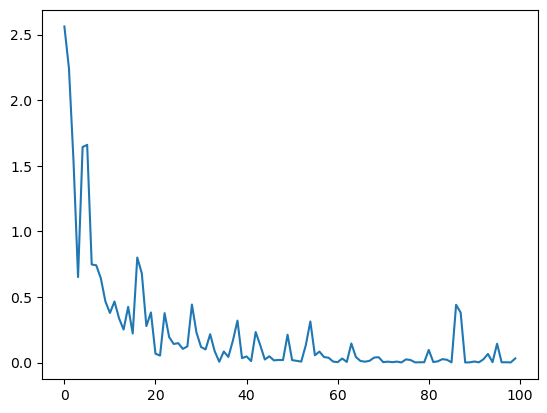

In [8]:
plt.plot(history)
plt.show()
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/")

(912,) (912,)


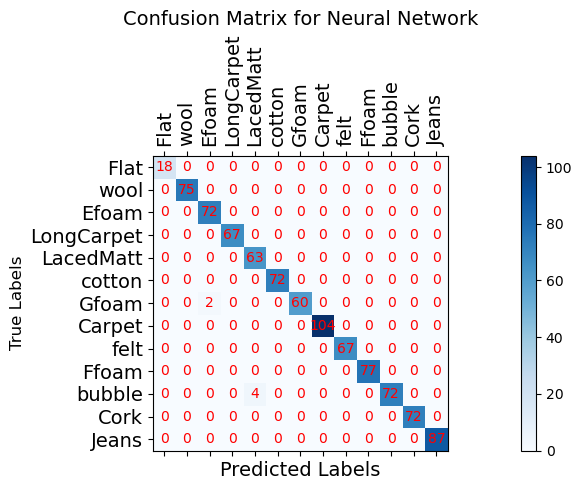

In [9]:
preds=None
real=None
keys={'Cork': 38, 'wool': 19, 'LacedMatt': 28, 'Gfoam': 30, 'Carpet': 31, 'bubble': 37, 'Efoam': 21, 'cotton': 29, 'LongCarpet': 25, 'Flat': 16, 'felt': 34, 'Jeans': 39, 'Ffoam': 36}
inv_map = {v: k for k, v in keys.items()}  
for i, (inputs, labels) in enumerate(test_loader):
    outputs = model(inputs)
    a=torch.argmax(outputs.detach(),axis=1)
    if type(preds)==type(None):
        preds=a.numpy().copy()
        real=np.argmax(labels.numpy().copy(),axis=1)
    else:
        preds=np.concatenate([preds,a.numpy().copy()])
        real=np.concatenate([real,np.argmax(labels.numpy().copy(),axis=1)])


def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(real)
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix

print(real.shape,preds.shape)
# Combine all predictions
predictions = [preds]
model_names = ['Neural Network']
num_classes = len(np.unique(real))
un=np.unique(real)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(15, 5))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(real, preds, num_classes=len(np.unique(real)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{value}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([inv_map[unique[j]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([inv_map[unique[j]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.show()

In [31]:
torch.save(model.state_dict(), "C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel"

In [3]:
model = SimpleCNN(abs(0-4)*110,120).to(device)
model.load_state_dict(torch.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel"))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=211200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
  (relu): ReLU()
)

In [15]:
#perform on unseen pressures

#load in numpy
data=np.load(datapath+"datasets/X_texture_pout.npz")
for array_name in data:
    x_unseen=(data[array_name].astype(np.uint8))
data=np.load(datapath+"datasets/y_texture_pout.npz")
for array_name in data:
    y_unseen=(data[array_name].astype(np.uint8))
print(x_unseen.shape)
#cut temporal size
x_unseen=x_unseen[:,0:4]
X=np.zeros_like(x_unseen)
#apply sobel filter
for i in range(len(x_unseen)): #crop all images individually
    for j in range(len(x_unseen[0])):
        image=x_unseen[i][j]
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        X[i][j]=sobel_combined
unique_=["Flat","wool","Efoam","LongCarpet","LacedMatt","cotton","Gfoam","Carpet","felt","Ffoam","bubble","Cork","Jeans"]
keys={'Cork': 38, 'wool': 19, 'LacedMatt': 28, 'Gfoam': 30, 'Carpet': 31, 'bubble': 37, 'Efoam': 21, 'cotton': 29, 'LongCarpet': 25, 'Flat': 16, 'felt': 34, 'Jeans': 39, 'Ffoam': 36}
        
unique_={i:keys[unique_[i]] for i in range(len(unique_))}

#concat
X=X.reshape((4,len(X)//4,1,abs(0-4)*110,120))
X=torch.tensor(X, dtype=torch.float32).to(device)
y=y_unseen.reshape(4,len(y_unseen)//4)
print(X.shape,unique_)
#run through model
predsA=torch.argmax(model(X[0]),axis=1).detach().numpy()
predsB=torch.argmax(model(X[1]),axis=1).detach().numpy()
predsC=torch.argmax(model(X[2]),axis=1).detach().numpy()
predsD=torch.argmax(model(X[3]),axis=1).detach().numpy()
data=np.array([predsA,predsB,predsC,predsD])
for i,batch in enumerate(data):
    for key in np.unique(batch):
        batch[batch==key]=unique_[key]
data=data.reshape((len(x_unseen)))
y=y.reshape((len(x_unseen)))

#show accuracy (maybe confusion matrix of sorts)
correct=0
summed=0.1
a=data==y
summed+=len(x_unseen)
correct+=len(a[a==1])
print("Accuracy:",(correct/summed)*100,"%")

(800, 20, 110, 120)
torch.Size([4, 200, 1, 440, 120]) {0: 16, 1: 19, 2: 21, 3: 25, 4: 28, 5: 29, 6: 30, 7: 31, 8: 34, 9: 36, 10: 37, 11: 38, 12: 39}
Accuracy: 99.9875015623047 %


# Vis

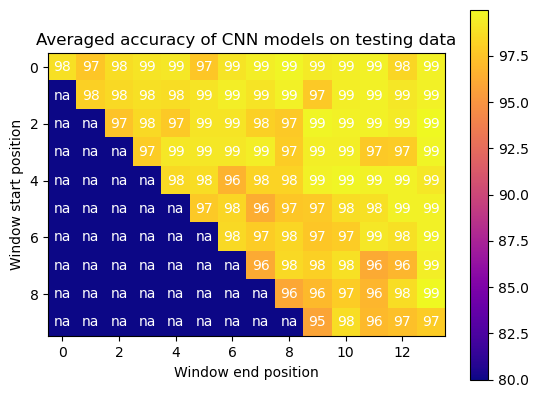

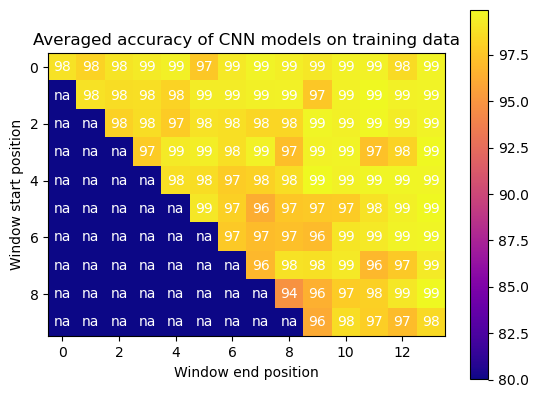

In [16]:
test=np.load(path+"saves/test_scores.npy")
train=np.load(path+"saves/train_scores.npy")

test=np.max(test,axis=2)*100
"""test=(test-np.min(test))/(np.max(test)-np.min(test))
test*=255"""
test[test==0]=80
plt.imshow(test,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        num=int(test[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')

plt.title("Averaged accuracy of CNN models on testing data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()



train=np.max(train,axis=2)*100
train[train==0]=80
plt.imshow(train,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(train.shape[0]):
    for j in range(train.shape[1]):
        num=int(train[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')
plt.title("Averaged accuracy of CNN models on training data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()

## Feature layer

In [ ]:
model = SimpleCNN(abs(0-4)*110,120).to(device)
model.load_state_dict(torch.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel"))
model.eval()

data=loaded(0,4)
data.applySobel()
sample_of_data=data.X[0:10]
x_data=data.X[0:4].reshape((len(data.X[0:4]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data))
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)


(110, 30)


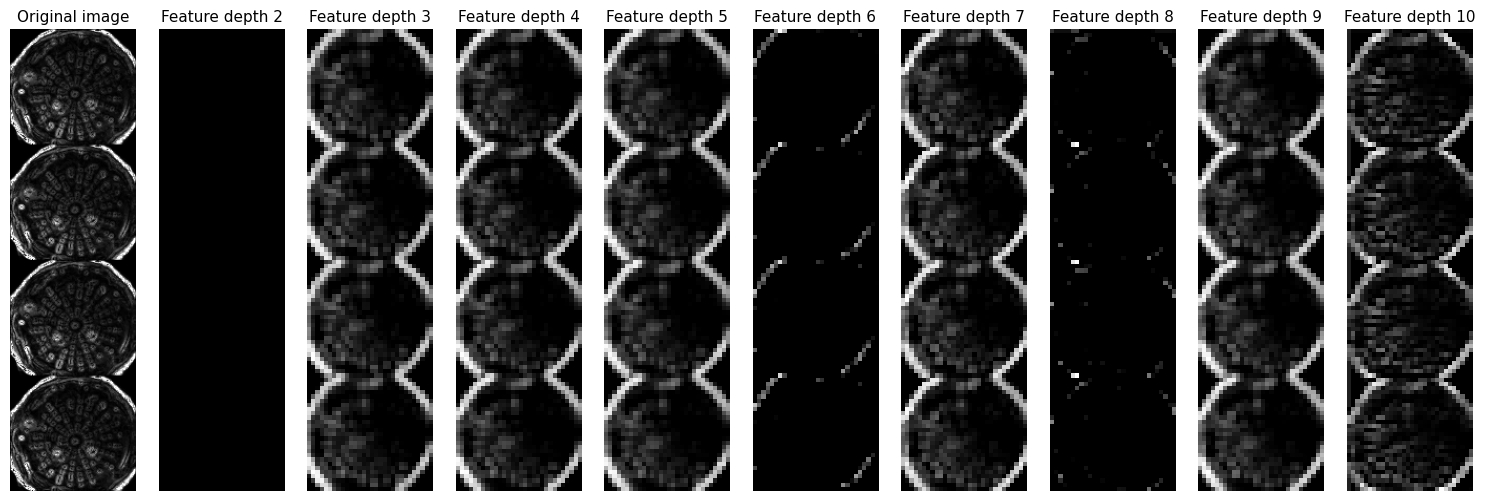

In [49]:
#forward pass
x = model.pool(model.relu(model.conv1(train_images_tensor)))
x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
print(x[0][0].shape)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
axes = axes.flatten()
axes[0].imshow(train_images_tensor[0][0].cpu().detach().numpy(),cmap="gray")
axes[0].axis("off")
axes[0].set_title("Original image",fontsize=11)
for i in range(1,10):
    axes[i].imshow(x[2][i],cmap="gray")
    axes[i].axis("off")
    axes[i].set_title("Feature depth "+str(i+1),fontsize=11)
plt.tight_layout()
plt.savefig("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/featuresALL.pdf")
plt.show()

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data=loaded(t=4)
data.applySobel()
data.augment()

# Reduce dimensionality with PCA
pca = PCA(n_components=833)
x_data=data.X[0:].reshape((len(data.X[0:]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
labels=data.y[0:]
print(x_data.reshape(len(x_data), -1).shape)
pca_features = pca.fit_transform(x_data.reshape(len(x_data), -1))

# Further reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='tab20')
plt.colorbar()
plt.title('t-SNE Visualization of Optical Tactile Sensor Images')
plt.savefig(path+"/images/clusters.pdf")
plt.show()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
(9000, 52800)


: 

: 

# Point prediction

In [ ]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p
sample=data.X[0:750]
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)+140
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()